# Final Project - camera calibration and undistortion

In [17]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

In [18]:
def only_one_chessboard(gray_image,type,n):
    """
    Args:
    gray_image (ndarray): grayscale of current image, 
    type (int): number indicating type if checkerboard
    n (int): number indicating number of checkerboard of current type

    Returns:
        image: the checkerboard to look at
    """    
    
    address = 'templates/' + str(type) + '_board_' + str(n) + '.png'
    template = cv2.imread(address)
    template = template[...,0]
    res = cv2.matchTemplate(gray_image, template, cv2.TM_CCORR_NORMED)

    _, _, _, max_loc = cv2.minMaxLoc(res)
    top_left = max_loc
    bottom_right = (top_left[0] + template.shape[1], top_left[1] + template.shape[0])
    
    #gray_image[top_left[0]:bottom_right[0], top_left[1]:bottom_right[1]] = 0
    one_chessboard = gray_image
    one_chessboard[0:top_left[1],...] = 125
    one_chessboard[...,0:top_left[0]] = 125
    one_chessboard[bottom_right[1]:gray_image.shape[0],...] = 125
    one_chessboard[...,bottom_right[0]:gray_image.shape[1]] = 125
    
    return one_chessboard

In [19]:
def findMultipleChessCorners(nb_horizontal, nb_vertical, nb_board, type, img, objpoints, imgpoints, time=0):
    """Function finding chessboard corners of multiple checkerboards
    Args:
        nb_horizontal (int): number of horizontal corners
        nb_vertical (int): number of vertical corners
        nb_board (int): board type number
        type (int): board type
        img (ndarray): _description_
        objpoints (list): list of object points
        imgpoints (_type_): list of image points
        time (int, optional): time to display the found corners. Defaults to 0.

    Returns:
        objpoints, imgpoints (list, list): list of object points and list of image points 
    """    
    img_with_corners = img
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    for i in range(1,nb_board):
        objp = np.zeros((nb_horizontal*nb_vertical,3), np.float32)
        objp[:,:2] = np.mgrid[0:nb_horizontal,0:nb_vertical].T.reshape(-1,2)
        current_gray = only_one_chessboard(gray,type,i)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        ret, corners = cv2.findChessboardCornersSB(current_gray, (nb_horizontal,nb_vertical), flags=cv2.CALIB_CB_EXHAUSTIVE)

        # If found, add object points, image points (after refining them)
        if ret == True:
            objpoints.append(objp)
            corners = cv2.cornerSubPix(current_gray,corners,(5,5),(-1,-1),criteria)
            imgpoints.append(corners)

            # Draw and display the corners if wanted
            if time != 0:
                img_with_corners = cv2.drawChessboardCorners(img_with_corners, (nb_horizontal,nb_vertical), corners,ret)
                cv2.imshow('img',img_with_corners)
                cv2.waitKey(time)
    
    return objpoints, imgpoints

In [20]:
def findAllChessCorners(images):
    """Function looping through all the images and finding the corners of all 
    the checkerboards

    Args:
        images (glob): glob pointing to the images

    Returns:
        objpoints (list): list of all the object points
        imgpoints (list): list of all the image points
    """    
    objpoints = [] # 3d point in real world space
    imgpoints = [] # 2d points in image plane.
    
    for fname in images:
        img = cv2.imread(fname)
        
        # Find the chess board corners for the boards with shape (7,5)
        nb_horizontal = 7
        nb_vertical = 5
        objpoints, imgpoints = findMultipleChessCorners(nb_horizontal, nb_vertical, 
                                                        6, 1, img, objpoints, imgpoints)

        # Find the chess board corners for the boards with shape (5,7)
        nb_horizontal = 5
        nb_vertical = 7
        objpoints, imgpoints = findMultipleChessCorners(nb_horizontal, nb_vertical, 
                                                        6, 2, img, objpoints, imgpoints)
        # Find the chess board corners for the boards with shape (11,7)
        nb_horizontal = 11
        nb_vertical = 7
        objpoints, imgpoints = findMultipleChessCorners(nb_horizontal, nb_vertical, 
                                                        3, 3, img, objpoints, imgpoints)
        # Find the chess board corners for the board with shape (5,15)
        nb_horizontal = 5
        nb_vertical = 15
        objpoints, imgpoints = findMultipleChessCorners(nb_horizontal, nb_vertical,
                                                        2, 4, img, objpoints, imgpoints)
        cv2.destroyAllWindows()
    return objpoints, imgpoints

In [42]:
def undistortAll(images, cameraMatrix, dist, newCameraMatrix, roi, side):
    """
    Function to undistort and crop all images in a folder and save them in a 
    new "undistorted/" folder
    Args:
    images (glob): glob pointing to the images to undistort
    cameraMatrix (ndarray): the camera matrix
    dist (ndarray): distortion coefficients
    newCameraMatrix (ndarray): new refined camera matrix 
    """    
    for fname in images:
        img = cv2.imread(fname)
        undistorted = cv2.undistort(img, cameraMatrix, dist, None, newCameraMatrix)
        x,y,w,h = roi
        undistorted = undistorted[y:y+h, x:x+w]
        cv2.imwrite("final_project_data/undistorted/" + side + "/" + fname.split("/")[-1], undistorted)        

In [21]:
# Load the left and right images
left_imgs = glob.glob("final_project_data/calib/image_02/data/*.png", recursive=True)
right_imgs = glob.glob("final_project_data/calib/image_03/data/*.png", recursive=True)

In [22]:
#NOTE: this takes ~40 seconds to run
leftobjpoints, leftimgpoints = findAllChessCorners(left_imgs)
rightobjpoints, rightimgpoints = findAllChessCorners(right_imgs)

In [28]:
#NOTE: this takes a while to run (~3 minutes)
# Getting left camera matrix
left_img = cv2.imread('final_project_data/calib/image_02/data/0000000000.png')
left_gray = cv2.imread('final_project_data/calib/image_02/data/0000000000.png', cv2.IMREAD_GRAYSCALE)
ret, left_mtx, left_dist, rvecs, tvecs = cv2.calibrateCamera(leftobjpoints, leftimgpoints, left_gray.shape[::-1], None, None)
h, w = left_img.shape[:2]
new_left_mtx, roi = cv2.getOptimalNewCameraMatrix(left_mtx,left_dist,(w,h),1,(w,h))

In [45]:
#NOTE: this takes a while to run (~2 minutes)
# Getting right camera matrix
right_img = cv2.imread('final_project_data/calib/image_03/data/0000000000.png')
right_gray = cv2.imread('final_project_data/calib/image_03/data/0000000000.png', cv2.IMREAD_GRAYSCALE)
ret, right_mtx, right_dist, rvecs, tvecs = cv2.calibrateCamera(rightobjpoints, rightimgpoints, right_gray.shape[::-1], None, None)
h, w = right_img.shape[:2]
new_right_mtx, roi = cv2.getOptimalNewCameraMatrix(right_mtx,right_dist,(w,h),1,(w,h))

In [44]:
# Undistort all the images, and save them in respective "undistorted" folders
undistortAll(left_imgs, left_mtx, left_dist, new_left_mtx, roi, "left")
undistortAll(right_imgs, right_mtx, right_dist, new_right_mtx, roi, "right")

Text(0.5, 1.0, 'Undistorted image')

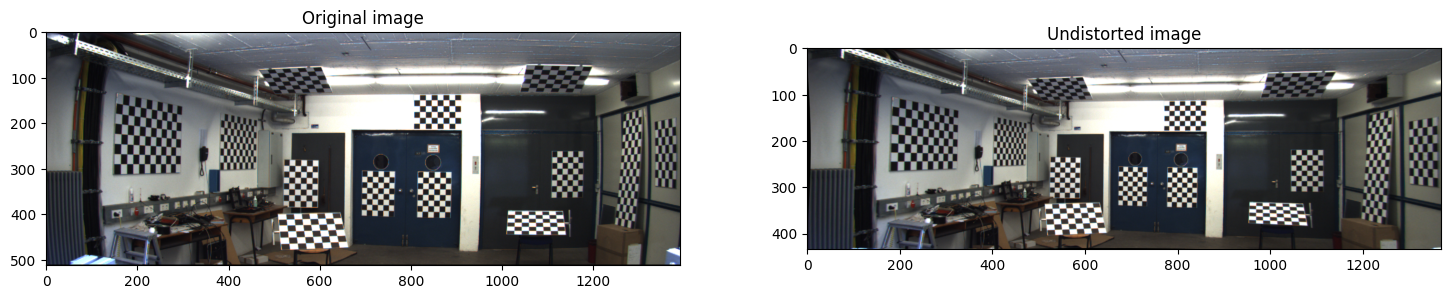

In [47]:
# Undistort the left image
left_dst = cv2.undistort(left_img, left_mtx, left_dist, None, new_left_mtx)
# crop the image
x,y,w,h = roi
left_dst = left_dst[y:y+h, x:x+w]
# Plot the original and undistorted image side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,18))
ax[0].imshow(left_img[...,[2,1,0]])
ax[0].set_title('Original image')
ax[1].imshow(left_dst[...,[2,1,0]])
ax[1].set_title('Undistorted image')

Text(0.5, 1.0, 'Undistorted image')

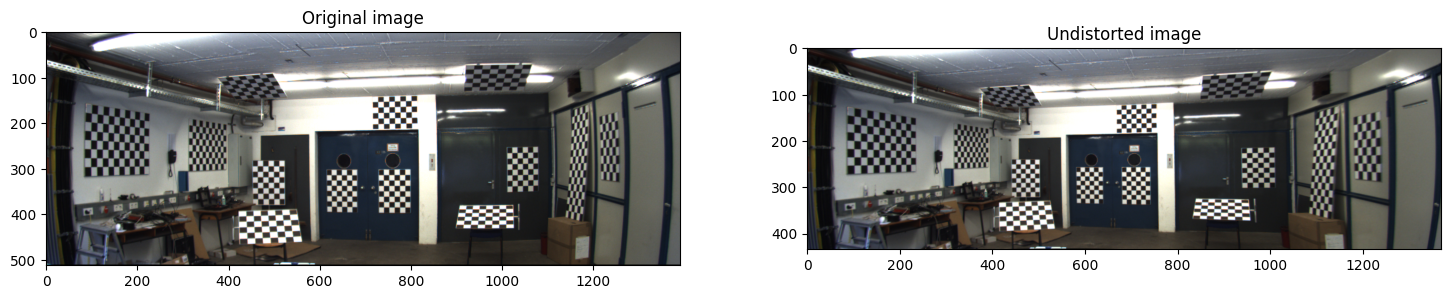

In [50]:
# Undistort the right image
right_dst = cv2.undistort(right_img, right_mtx, right_dist, None, new_right_mtx)
# crop the image
x,y,w,h = roi
right_dst = right_dst[y:y+h, x:x+w]
# Plot the original and undistorted image side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,18))
ax[0].imshow(right_img[...,[2,1,0]])
ax[0].set_title('Original image')
ax[1].imshow(right_dst[...,[2,1,0]])
ax[1].set_title('Undistorted image')

# Undistortion done for each camera individually
## below, stereo rectification will be performed

In [51]:
# Stereo calibrate the cameras using the two camera matrices
ret, left_mtx, left_dist, right_mtx, right_dist, R, T, E, F = \
cv2.stereoCalibrate(leftobjpoints, leftimgpoints, rightimgpoints, 
                    new_left_mtx, left_dist, new_right_mtx, right_dist, 
                    left_gray.shape[::-1])

error: OpenCV(4.7.0) /io/opencv/modules/calib3d/src/calibration.cpp:3396: error: (-2:Unspecified error) in function 'void cv::collectCalibrationData(cv::InputArrayOfArrays, cv::InputArrayOfArrays, cv::InputArrayOfArrays, int, cv::Mat&, cv::Mat&, cv::Mat*, cv::Mat&)'
>  (expected: 'nimages == (int)imagePoints2.total()'), where
>     'nimages' is 247
> must be equal to
>     '(int)imagePoints2.total()' is 231


In [47]:
left_rotation_mtx, right_rotation_mtx, left_projection_mtx, right_projection_mtx, \
disparity_to_depth_mtx, left_roi, right_roi = cv2.stereoRectify(left_mtx, \
                                            left_dist, right_mtx, right_dist, \
                                            left_gray.shape[::-1], R, T, alpha=-1)
# alpha=-1 means that the rectified images' black parts are optimized by OpenCV
# 0 gives no black borders, 1 keeps the black borders, anything in between is a
# gamble

In [ ]:
#NOTE: can the two functions below be replaced by simply cv2.undiort() like above?
# ref: https://docs.opencv.org/4.x/dc/dbb/tutorial_py_calibration.html#:~:text=1.%20Using%20cv.undistort()

In [48]:
left_mapx, left_mapy = cv2.initUndistortRectifyMap(left_mtx, left_dist, left_rotation_mtx, \
                                                    left_projection_mtx, left_gray.shape[::-1], cv2.CV_32FC1)

In [49]:
right_mapx, right_mapy = cv2.initUndistortRectifyMap(right_mtx, right_dist, right_rotation_mtx, \
                                                    right_projection_mtx, right_gray.shape[::-1], cv2.CV_32FC1)

In [50]:
rectified_left = cv2.remap(left_gray, left_mapx, left_mapy, cv2.INTER_LINEAR, cv2.BORDER_CONSTANT)
rectified_right = cv2.remap(right_gray, right_mapx, right_mapy, cv2.INTER_LINEAR, cv2.BORDER_CONSTANT)